1. Upload Your Images in Colab

In [ ]:
from google.colab import files

# Upload content and style images
uploaded = files.upload()  # Upload two images (content and style)

# Assign paths to uploaded files
content_path = list(uploaded.keys())[0]  # First uploaded file
style_path = list(uploaded.keys())[1]    # Second uploaded file


Saving the-starry-night-1889.jpg!Large.jpg to the-starry-night-1889.jpg!Large.jpg
Saving leighton-smith-NPxkSK-makg-unsplash.jpg to leighton-smith-NPxkSK-makg-unsplash.jpg


2. Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


3. Load and Preprocess the Images

In [ ]:
# Function to load and preprocess images for VGG19
def load_and_process_image(image_path, target_size=(512, 512)):
    img = Image.open(image_path).resize(target_size)  # Open and resize image
    img = np.array(img)  # Convert image to a NumPy array
    img = tf.keras.applications.vgg19.preprocess_input(img)  # Preprocess for VGG19
    return tf.convert_to_tensor(img, dtype=tf.float32)[tf.newaxis, ...]  # Add batch dimension

# Function to deprocess the image for display
def deprocess_image(image_tensor):
    img = image_tensor.numpy().squeeze()  # Remove batch dimension
    img = (img + 1.0) * 127.5  # Rescale pixel values
    img = np.clip(img, 0, 255).astype(np.uint8)  # Clip to valid range
    return Image.fromarray(img)  # Convert to PIL image


4. Display Images

In [ ]:
# Function to display images
def show_images(content, style, generated):
    plt.figure(figsize=(15, 5))
    titles = ['Content Image', 'Style Image', 'Generated Image']
    images = [content, style, generated]
    for i, img in enumerate(images):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


5. Load the VGG19 Model

In [ ]:
# Load the VGG19 model
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights="imagenet")  # Load pre-trained VGG19
    vgg.trainable = False  # Freeze the model
    # Extract layers needed for style and content
    outputs = {layer.name: layer.output for layer in vgg.layers}
    return tf.keras.Model(inputs=vgg.input, outputs=outputs)


6. Define Loss Functions

In [ ]:
# Compute the Gram matrix for style loss
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)  # Compute dot product
    shape = tf.shape(tensor)
    normalization = tf.cast(shape[1] * shape[2], tf.float32)  # Normalize by image size
    return result / normalization

# Compute total loss
def compute_loss(model, generated, content_features, style_features):
    outputs = model(generated)
    content_loss = tf.reduce_mean((outputs['block5_conv2'] - content_features) ** 2)
    style_loss = 0
    for layer_name in style_features.keys():
        gen_gram = gram_matrix(outputs[layer_name])
        style_gram = style_features[layer_name]
        style_loss += tf.reduce_mean((gen_gram - style_gram) ** 2)
    total_loss = 1e4 * style_loss + content_loss  # Weighted combination
    return total_loss


7. Style Transfer

In [ ]:
# Perform style transfer
def style_transfer(content_path, style_path, iterations=100):
    # Load images
    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)
    generated_image = tf.Variable(content_image)  # Start with the content image

    # Load VGG19 model and extract features
    model = get_model()
    content_features = model(content_image)['block5_conv2']
    style_features = {layer: gram_matrix(model(style_image)[layer]) for layer in ['block1_conv1', 'block2_conv1']}

    # Optimizer
    optimizer = tf.optimizers.Adam(learning_rate=0.02)

    # Optimize the generated image
    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, generated_image, content_features, style_features)
        gradients = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
        if i % 10 == 0:
            print(f"Iteration {i}/{iterations} - Loss: {loss.numpy()}")

    return deprocess_image(generated_image)


8. Run the Style Transfer

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Iteration 0/100 - Loss: 695451975680.0
Iteration 10/100 - Loss: 658044092416.0
Iteration 20/100 - Loss: 622517420032.0
Iteration 30/100 - Loss: 588978257920.0
Iteration 40/100 - Loss: 557443186688.0
Iteration 50/100 - Loss: 527861514240.0
Iteration 60/100 - Loss: 500140965888.0
Iteration 70/100 - Loss: 474172358656.0
Iteration 80/100 - Loss: 449852506112.0
Iteration 90/100 - Loss: 427082121216.0


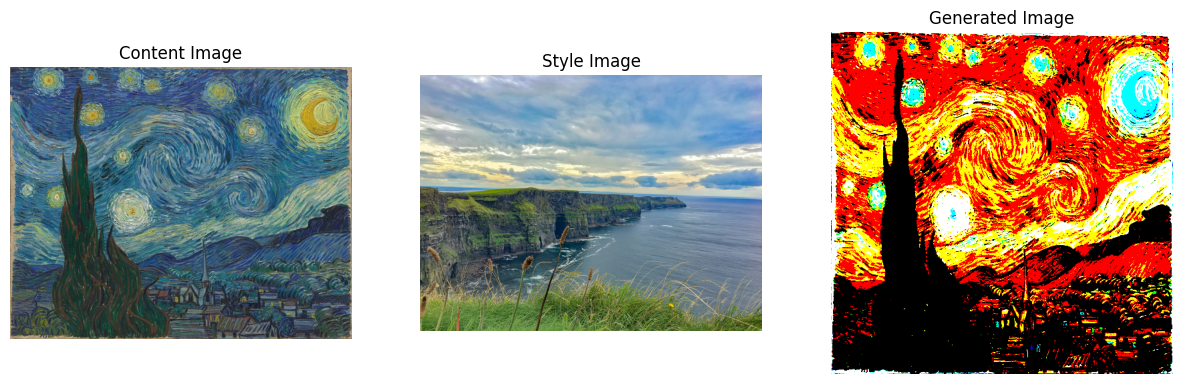

Stylized image saved as stylized_image.jpg


In [ ]:
# Run style transfer
output_image = style_transfer(content_path, style_path)

# Load original images for display
content_image = Image.open(content_path)
style_image = Image.open(style_path)

# Show content, style, and generated images
show_images(content_image, style_image, output_image)

# Save the generated image
output_image.save("stylized_image.jpg")
print("Stylized image saved as stylized_image.jpg")


9. Download the Generated Image

In [ ]:
from google.colab import files
files.download("stylized_image.jpg")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>